Doublewell potential
===========

In this notebook we study the rare-event kinetics of a Markov jump process in the asymmetric doublewell potential. The neighborhood of the two minima of the potential are the interesting meta-stable sets for the jump-process. 

We focuss our study on the largest relaxation time-scale, $t_2$ of the system. The largest relaxation time-scale describes the relaxation time-scale for an average starting distribution to relax to the equilibrium distribution (stationary vector/invariant distribution) of the Markov jump-process.

We show that this timescale can be efficiently estimated if short relaxation trajectories (starting on the barrier) and the stationary vector are combined using reversible MSMs.

We compare the estimated values with those obtained from an ensemble of long trajectories using the standard approach (non-reversible MSM, no additional information about stationary probabilities) and show that the timescale value can be reliably estimated with much smaller total simulation effort if additional knowledge about the stationary probabilities is available during MSM estimation.

We carry out a full Bayesian posterior analysis to quantify the uncertainties of all estimates and show that orders of magnitude speedup can be achieved if short relaxation trajectories are used in combination information about the stationary vector of the Markov process.

We start with a few general imports and settings

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import msmtools.generation as msmgen
import pyemma.msm as msm

Setting up the system
-------------------------

We define the functional form for the asymmetric doublewell potential, $V(x)$ and specify the potential parameters, $s$, $d$, giving rise to meta-stable dynamics.

To carry out MSM analysis we need to discretize the continous space into finitely many non-overlapping sets. We choose $n_x=100$ equally spaced bins to discretize the interval $[-L, L]$ with $L=3.4$. We restrict our process to this set since the probability to find the process outside this interval is neglegible.

We obtain the stationary probabilities for the process according to the standard Boltzmann weights

$$ \pi_i = Z^{-1} e^{-\beta V(x_i)} $$

with $\beta$ the inverse temperature and $Z$ determined by the normalisation condition,

$$ \sum_i \pi_i = 1. $$

The system dynamics are given by a transition matrix of conditional jump probabilities, $P=(p_{ij})$, with 

$$ p_{ij} = 
\begin{cases} 
        0.5 \min \left\{ 1, \frac{\pi_j}{\pi_i} \right \} &\mbox{if } j = i \pm 1 \\
        1 - \sum_{j \neq i} p_{ij} & \mbox{if } j=i \\
        0 & \mbox{else}
\end{cases}
$$

given according to the Metropolis-Rosenbluth rule [4].

Finally we can compute the reference relaxation timescales from the transition matrix.

The largest relaxation timescale for the process is 1.415e+06 steps


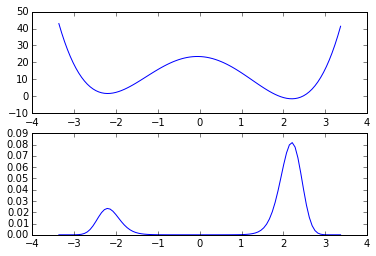

In [2]:
def V(x, s, d):
    return (x**2-s**2)**2 + s*d*(1.0/3*x**3 - s**2*x)
# Potential parameters
s = 2.2
d = 0.1
# Discretisation
L = 3.4
nx = 100
xedges = np.linspace(-L, L, nx+1)
dx = xedges[1]-xedges[0]
xcenters = xedges[0:-1]+0.5*dx
# Stationary vector
kB=8.314472471220217*1e-3 # kJ/(K*mol)
T=300.0 # K
beta=1.0/(kB*T) # mol/kJ
nu_ref = np.exp(-beta*V(xcenters, s, d))
pi_ref = nu_ref/nu_ref.sum()
# Metropolis-Rosenbluth transition matrix
P_ref = msmgen.transition_matrix_metropolis_1d(beta*V(xcenters, s, d))
msm_ref = msm.markov_model(P_ref)
# Plot potential and stationary vector values at centers
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(xcenters, V(xcenters, s, d))
ax2 = fig.add_subplot(212)
ax2.plot(xcenters, pi_ref)
# Compute reference relaxation time scales
print "The largest relaxation timescale for the process is %.3e steps" %msm_ref.timescales(1)

MSM from long trajectories
------------------------------

Now we build a standard MSM (non-reversible, no additional information about the stationary vector)
using a set of $M=10$ trajectories of length $L=10000 \Delta t$ saved at a timestep $\Delta t_{long} = 1000$ steps.

All trajectories start at the minimum of the potential $x_0 = s$ and evolve according to the transition probabilities of the process at timestep $\Delta t$.

$$ P(\Delta t) = P^{\Delta t}. $$

The generated trajectories are used to estimate a MSM for the dynamics at timestep $\Delta t$. Since the dynamics was already Markovian at $\Delta t = 1$ we can choose a lagtime $\tau = 1$. The maximum likelihood relaxation timescale, $\hat{t}_2$, can now be computed from the estimated MSM.

In [3]:
start = np.argmin(np.abs(xcenters-s))
dt_long = 1000
dtrajs_long = msmgen.generate_trajs(P_ref, 100, 10000, dt=dt_long, start=start)

In [4]:
tau = 1
msm_nrev = msm.estimate_markov_model(dtrajs_long, tau)
print "Maximum likelihood value from MSM is %.6e steps" %(msm_nrev.timescales(1)*dt_long)

Maximum likelihood value from MSM is 1.485659e+06 steps


Computing errors
-------------------
To quantify the uncertainty of the estimated timescale we need to carry out a Bayesian posterior analysis, c.f. [3].

We draw transition matrices from the posterior ensemble and compute the timescale for each sampled transition matrix. The errors of our estimate can then assessed by the sample standard deviation.

In [5]:
bmsm = msm.bayesian_markov_model(dtrajs_long, tau, count_mode='sample', reversible=False)
print "The estimated sample mean is %.3e " %(bmsm.sample_mean('timescales', 1)*dt_long)
print "The estimated standard deviation is %.3e " %(bmsm.sample_std('timescales', 1)*dt_long)
print "The relative error of the estimate is %.1f" %(100.0*bmsm.sample_std('timescales', 1)/bmsm.sample_mean('timescales', 1)) +"%"

The estimated sample mean is 1.462e+06 
The estimated standard deviation is 1.013e+05 
The relative error of the estimate is 6.9%


MSM with fixed stationary vector and short 'downhill' trajectories
----------------------------------------------------------------------------

Estimates of the stationary probabilities can be obtained from enhanced sampling simulations using appropriate reweighting techniques (WHAM, MBAR, TRAM). The amount of data required to obtain reliable estimates can be orders of magnitude smaller than those required to obtain a good estimate from data generated using a standard simulation protocol, e.g. standard MD.

There is an additional cost for the enhanced sampling simulations. The obtained estimates also come with a statistical uncertainty which can be quantified using bootstrap resampling techniques.

We use a stationary vector obtained from $1000 \Delta t_{short}$ steps of umbrella sampling simulations and a set of $10000$ short trajectories of length $100 \Delta t_{short}$ starting on the barrier to estimate the relaxation timescale.

We also use a bootstrap sample of stationary vectors to quantify the errors resulting from the combined uncertainty of stationary vector estimate and finite amount of trajectories used.

The short trajectories start on the barrier and rapidly relax to the high probability regions around the potential minima. Using information about the stationary vector we can estimate the relaxation timescale using only short simulations that do not need to cross the barrier between the two meta-stable regions.

In [6]:
start = np.argmin(np.abs(xcenters + s*d/4.0))
dt_short = 10
dtrajs_short = msmgen.generate_trajs(P_ref, 10000, 100, dt=dt_short, start=start)
pi_bs = np.load('data/stationary_vector_bs.npy')[3, :, :]
n_bs = pi_bs.shape[0]
n_samples = 10

In [7]:
msm_revpi = msm.estimate_markov_model(dtrajs_short, tau, statdist=pi_ref)
print "Maximum likelihood value from MSM with fixed stationary vector"
print "%.3e steps" %(msm_revpi.timescales(1)*dt_short)

Maximum likelihood value from MSM with fixed stationary vector
1.413e+06 steps


Computing errors
-------------------

We again perform a Bayesian posterior analysis. Now for the ensemble of transition matrices reversible with respect to a given stationary vector, c.f. [3].

We show that for two orders of magnitude less simulation effort we get a drastically reduced error of our estimate if the stationary vector is used in combination with short trajectories relaxing from the barrier.

In [8]:
bmsm_revpi = msm.bayesian_markov_model(dtrajs_short, tau, statdist=pi_ref, count_mode='sample', nsamples=100)
print "The estimated sample mean is %.3e " %(bmsm_revpi.sample_mean('timescales', 1)*dt_long)
print "The estimated standard deviation is %.3e " %(bmsm_revpi.sample_std('timescales', 1)*dt_long)
print "The relative error of the estimate is %.1f" %(100.0*bmsm_revpi.sample_std('timescales', 1)/bmsm_revpi.sample_mean('timescales', 1)) +"%"

The estimated sample mean is 1.415e+08 
The estimated standard deviation is 5.685e+05 
The relative error of the estimate is 0.4%


Combined uncertainty
-----------------------
The relative error taking also into account the uncertainty in the stationary vector will be larger than the relative error taking into account only the finite amount of simulation data used.
 
We have to generate samples for each of the stationary vectors in the bootstrap, that can take a couple of minutes.

In [9]:
def sample_ts_bs(dtraj_list, pi_bs, n_samples, verbose=False):
    n_bs = pi_bs.shape[0]
    sample = np.zeros((n_bs*n_samples))    
    for i in range(n_bs):
        if verbose:
            print "Iteration %i of %i" %(i+1, n_bs)
        pi = pi_bs[i, :]
        bmsm_revpi = msm.bayesian_markov_model(dtraj_list, tau, statdist=pi_ref, 
                                               count_mode='sample', nsamples=n_samples, show_progress=False)
        sample[i*n_samples:(i+1)*n_samples] = bmsm_revpi.sample_f('timescales', 1)
    return sample

In [10]:
samples = sample_ts_bs(dtrajs_short, pi_bs, n_samples)
print "The estimated sample mean is %.3e steps" %(np.mean(samples)*dt_short)
print "The estimated standard deviation is %.3e steps" %(np.std(samples)*dt_short)
print "The relative error of the estimate is %.1f" %(100.0*np.std(samples)/np.mean(samples)) +"%"

The estimated sample mean is 1.414e+06 steps
The estimated standard deviation is 6.245e+03 steps
The relative error of the estimate is 0.4%


Error versus total simulation effort
-----------------------------------------

To study the uncertainty of the estimates for increasing amount of simulation data we need to estimate mean and uncertainty for an increasing number of short trajectories. Due to the large number of samples required to estimate a single data-point the evaluation of the below cells can take some time.

The results show that the relaxation time-scale can be reliably estimated before a single rare-event would have occured on average if short relaxation trajectories are used in combination with stationary probabilities estimated from enhanced sampling simulations.

In [11]:
def generate_stats(dtraj_list, N_dtrajs, pi_bs, n_samples):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print "Iteration %i of %i" %(i+1, len(N_dtrajs))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        sample = sample_ts_bs(dtraj_list[0:N], pi_bs, n_samples)
        data[i, 0] = np.mean(sample*dt_short)
        data[i, 1] = np.std(sample*dt_short)
    return data

def generate_stats_optimal(dtraj_list, N_dtrajs, pi_bs_list, n_samples):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print "Iteration %i of %i" %(i+1, len(N_dtrajs))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        sample = sample_ts_bs(dtraj_list[0:N], pi_bs_list[i, :, :], n_samples)
        data[i, 0] = np.mean(sample*dt_short)
        data[i, 1] = np.std(sample*dt_short)
    return data

def generate_stats_nrev(dtraj_list, N_dtrajs, n_samples):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print "Iteration %i of %i" %(i+1, len(N_dtrajs))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        bmsm = msm.bayesian_markov_model(dtraj_list[0:N], tau, count_mode='sample', 
                                         nsamples=n_samples, show_progress=False)
        sample = np.asarray(bmsm.sample_f('timescales', 1))
        data[i, 0] = np.mean(sample*dt_long)
        data[i, 1] = np.std(sample*dt_long)
    return data

stationary_vector_bs = np.load('data/stationary_vector_bs.npy')

In [12]:
N_dtraj = np.array([100, 200, 500, 1000, 2000, 5000, 10000])
pi_bs = stationary_vector_bs[3, :, :]
effort_short = N_dtraj * 100 * dt_short + 100000*dt_short # N_C + N_pi in dt
data_short = generate_stats(dtrajs_short, N_dtraj, pi_bs, n_samples)

Iteration 1 of 7
Iteration 2 of 7
Iteration 3 of 7
Iteration 4 of 7
Iteration 5 of 7
Iteration 6 of 7
Iteration 7 of 7


In [13]:
N_dtraj = np.array([100, 200, 500, 1000, 2000, 5000, 10000])
pi_bs = stationary_vector_bs[6, :, :]
effort_long = N_dtraj * 100 * dt_short + 1000000*dt_short # N_C + N_pi in ns
data_long = generate_stats(dtrajs_short, N_dtraj, pi_bs, n_samples)

Iteration 1 of 7
Iteration 2 of 7
Iteration 3 of 7
Iteration 4 of 7
Iteration 5 of 7
Iteration 6 of 7
Iteration 7 of 7


In [14]:
N_dtraj = np.array([5, 10, 20, 50, 100])
effort_nrev = N_dtraj*10000*dt_long  # N_C + N_pi in ns
data_nrev = generate_stats_nrev(dtrajs_long, N_dtraj, n_samples*n_bs)

Iteration 1 of 5
Iteration 2 of 5
Iteration 3 of 5
Iteration 4 of 5
Iteration 5 of 5


In [15]:
N_dtraj = np.array([200, 500, 1000, 2000, 5000, 10000])
effort_optimal = N_dtraj*100*dt_short*2
data_optimal = generate_stats_optimal(dtrajs_short, N_dtraj, stationary_vector_bs, n_samples)

Iteration 1 of 6
Iteration 2 of 6
Iteration 3 of 6
Iteration 4 of 6
Iteration 5 of 6
Iteration 6 of 6


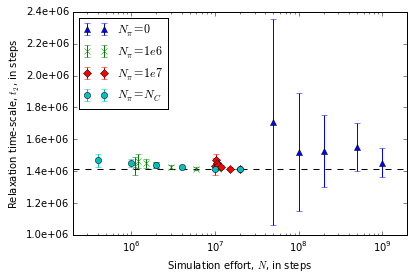

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Simulation effort, $N$, in steps")
ax.set_ylabel(r"Relaxation time-scale, $t_2$, in steps")
ax.set_xscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.set_xlim(2e5, 2e9)
ax.axhline(1.415e6, ls='--', c='k')
ax.errorbar(effort_nrev, data_nrev[:, 0], yerr=data_nrev[:, 1], ls=' ', marker='^',
           label=r"$N_{\pi}=0$")
ax.errorbar(effort_short, data_short[:, 0], yerr=data_short[:, 1], ls=' ', marker='x',
        label=r"$N_{\pi}=1e6$")
ax.errorbar(effort_long, data_long[:, 0], yerr=data_long[:, 1], ls=' ', marker='D',
           label=r"$N_{\pi}=1e7$")
ax.errorbar(effort_optimal, data_optimal[:, 0], yerr=data_optimal[:, 1], ls=' ', marker='o',
           label=r"$N_{\pi}=N_{C}$")
ax.legend(loc=2)

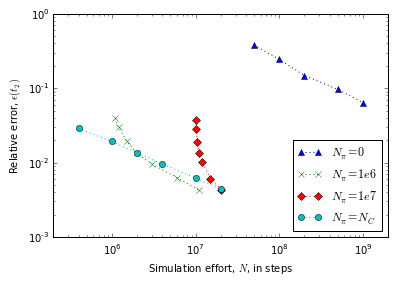

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Simulation effort, $N$, in steps")
ax.set_ylabel(r"Relative error, $\epsilon(t_2)$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2e5, 2e9)
ax.plot(effort_nrev, data_nrev[:, 1]/data_nrev[:, 0], ls=':', marker='^',
           label=r"$N_{\pi}=0$")
ax.plot(effort_short, data_short[:, 1]/data_short[:, 0], ls=':', marker='x',
        label=r"$N_{\pi}=1e6$")
ax.plot(effort_long, data_long[:, 1]/data_long[:, 0], ls=':', marker='D',
           label=r"$N_{\pi}=1e7$")
ax.plot(effort_optimal, data_optimal[:, 1]/data_optimal[:, 0], ls=':', marker='o',
           label=r"$N_{\pi}=N_{C}$")
ax.legend(loc=4)

References
------------

[1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Sarich, M., F. Noé, Ch. Schütte: On the Approximation Quality of Markov State Models. Multiscale Model. Simul. 8, 1154-1177 (2010)

[3] Trendelkamp-Schroer, B. and Wu, H. and Paul, F. and Noé, F. (2015) Estimation and uncertainty of reversible Markov models. J. Chem. Phys., 143 . p. 174101.

[4] N. Metropolis, A. Rosenbluth, M. Rosenbluth, A. Teller und E. Teller: Equation of State Calculations by Fast Computing Machines. In: Journal of Chemical Physics. 21, 1953, S. 1087-1092, 